<a href="https://colab.research.google.com/github/nilanshutwinkle/random-notes/blob/master/Sigmoid_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reading Data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/sigmoid/train (6).csv')
train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [ ]:
target = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/sigmoid/train_churn_labels.csv')
target.value_counts()

,count
Label,
-1,46328
1,3672


# EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 230 entries, Var1 to Var230
dtypes: float64(191), int64(1), object(38)
memory usage: 87.7+ MB


## Checking percentage of null values in each of the columns

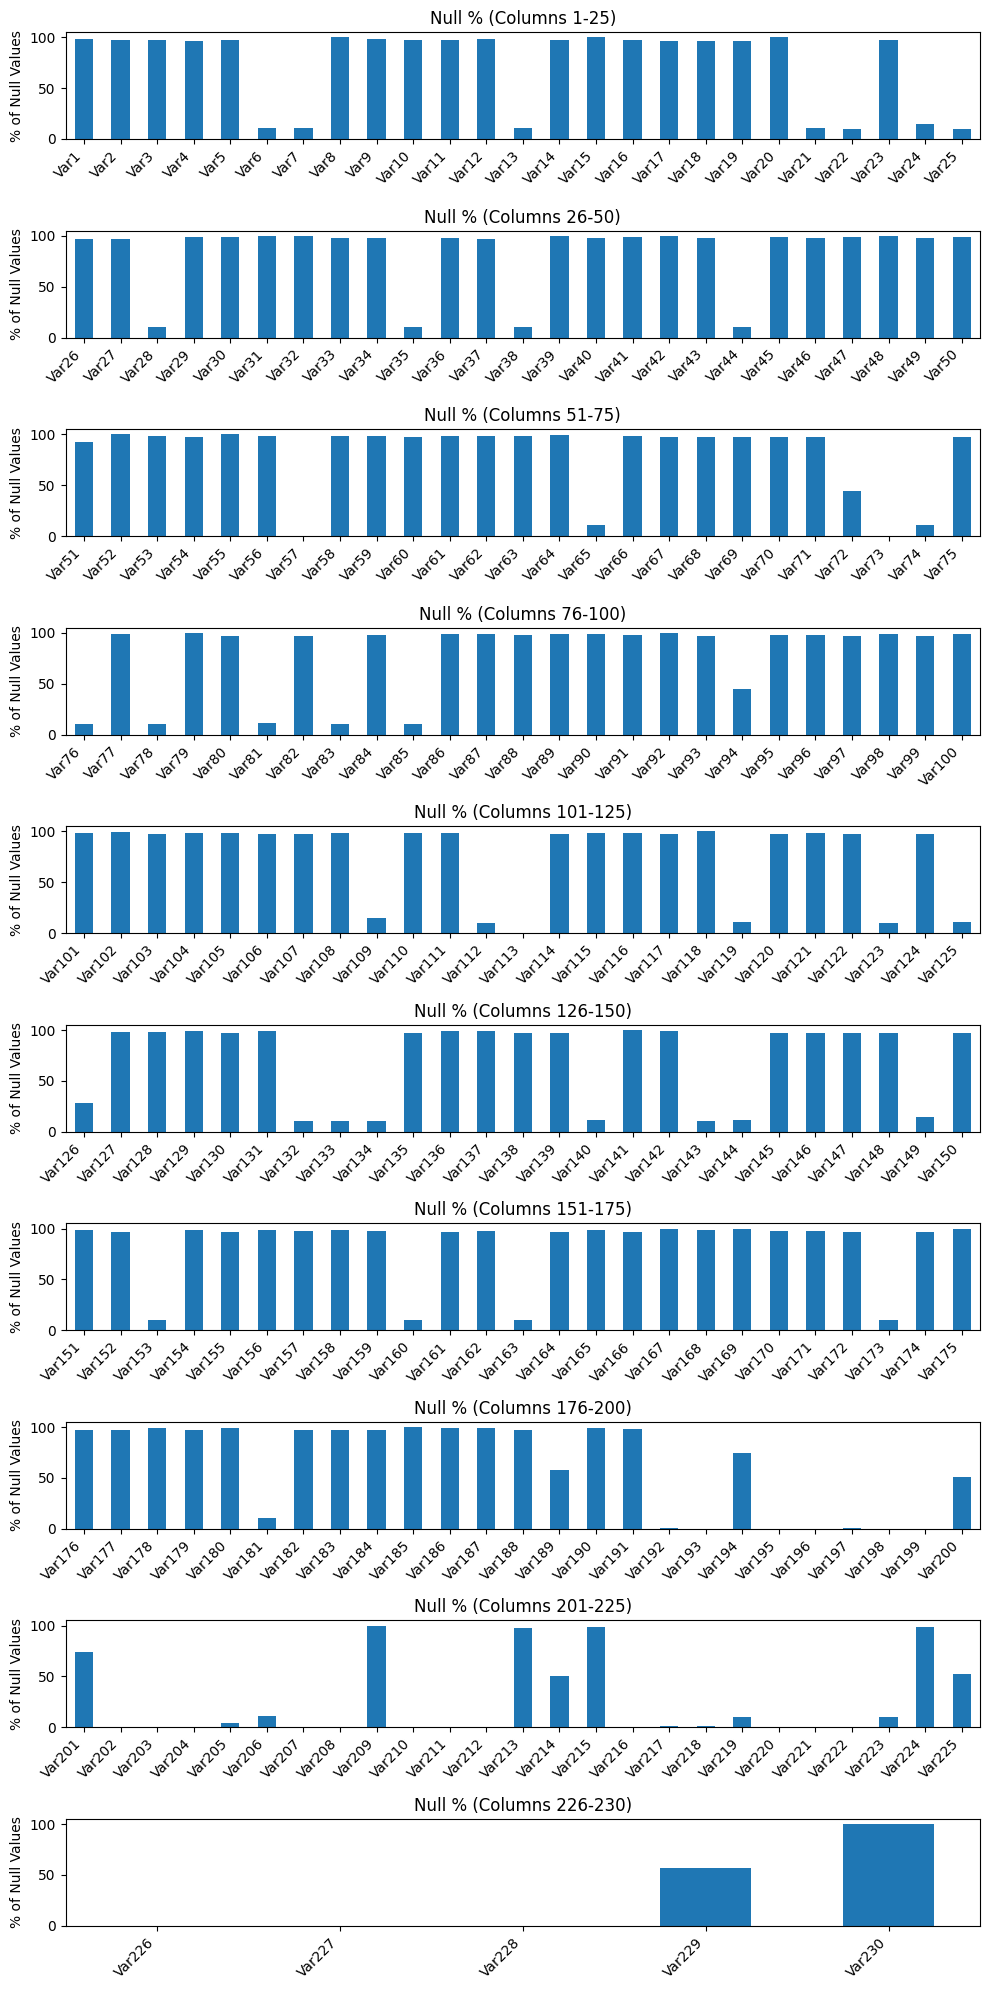

In [ ]:
def plot_null_percentage(df, batch_size):
    num_cols = len(df.columns)
    num_subplots = (num_cols + batch_size - 1) // batch_size  # Calculate the number of subplots needed

    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 2 * num_subplots))

    for i in range(num_subplots):
        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, num_cols)
        cols_to_plot = df.columns[start_index:end_index]

        null_percentages = df[cols_to_plot].isnull().sum() / len(df) * 100

        ax = axes[i] if num_subplots > 1 else axes # Handle single subplot case
        null_percentages.plot(kind='bar', ax=ax)
        ax.set_title(f'Null % (Columns {start_index+1}-{end_index})')
        ax.set_ylabel('% of Null Values')
        ax.set_xticklabels(cols_to_plot, rotation=45, ha='right')  # Rotate x-axis labels for better readability


    plt.tight_layout()
    plt.show()

# Example usage:
plot_null_percentage(train, batch_size=25) # Change batch_size as needed


## Plotting how many columns with null values more than the threshold

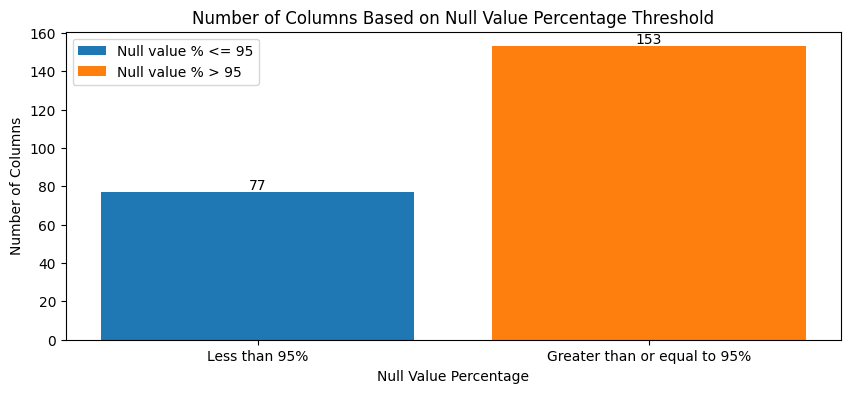

In [ ]:
def plot_null_threshold(df, threshold):
    null_counts = df.isnull().sum()
    total_rows = len(df)
    null_percentages = (null_counts / total_rows) * 100

    less_than_threshold = null_percentages[null_percentages < threshold]
    greater_than_threshold = null_percentages[null_percentages >= threshold]

    plt.figure(figsize=(10, 4))

    plt.bar(['Less than ' + str(threshold) + '%'], [len(less_than_threshold)], label=f'Null value % <= {threshold}')
    plt.bar(['Greater than or equal to ' + str(threshold) + '%'], [len(greater_than_threshold)], label=f'Null value % > {threshold}')

    # Annotate bars with the count of columns
    plt.annotate(str(len(less_than_threshold)), xy=(0, len(less_than_threshold)), ha='center', va='bottom')
    plt.annotate(str(len(greater_than_threshold)), xy=(1, len(greater_than_threshold)), ha='center', va='bottom')

    plt.xlabel('Null Value Percentage')
    plt.ylabel('Number of Columns')
    plt.title('Number of Columns Based on Null Value Percentage Threshold')
    plt.legend()
    plt.show()

# Example usage (assuming 'train' DataFrame is defined):
plot_null_threshold(train, 95)


- Removing all the columns with more than 95% of null values

In [ ]:
columns_with_gte_95_nulls = train.columns[(train.isnull().sum()/ train.shape[0]) >= 0.95]
train_ = train[[c for c in train.columns if c not in columns_with_gte_95_nulls]]
train_.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
0,1526.0,7.0,184.0,464.0,580.0,14.0,128.0,166.56,0.0,3570.0,...,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN
1,525.0,0.0,0.0,168.0,210.0,2.0,24.0,353.52,0.0,4764966.0,...,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN
2,5236.0,7.0,904.0,1212.0,1515.0,26.0,816.0,220.08,0.0,5883894.0,...,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c
3,NaN,0.0,0.0,NaN,0.0,NaN,0.0,22.08,0.0,0.0,...,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN
4,1029.0,7.0,3216.0,64.0,80.0,4.0,64.0,200.00,0.0,0.0,...,FzaX,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86


- Heatmap of null values in the selected columns

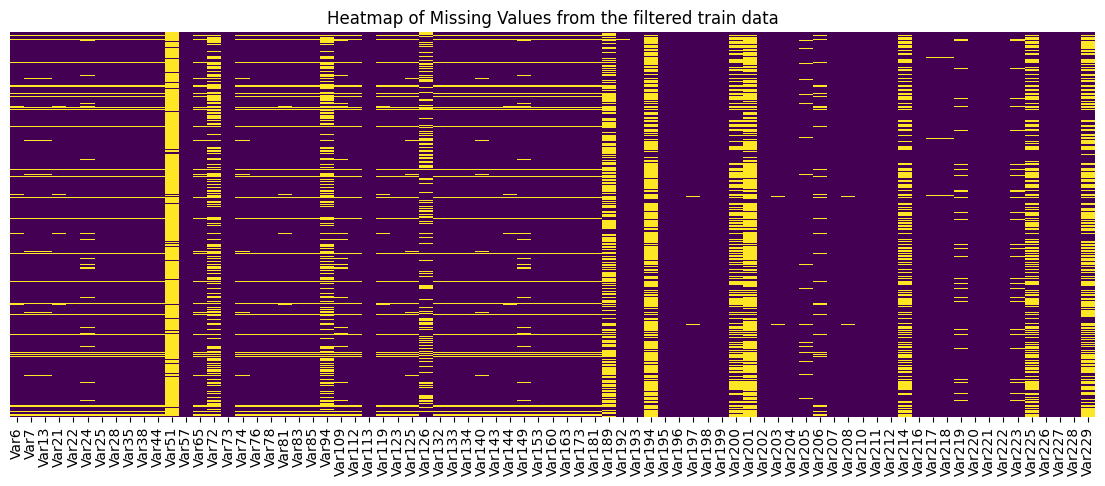

In [ ]:
plt.figure(figsize=(14, 5))
sns.heatmap(train_.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Heatmap of Missing Values from the filtered train data')
plt.show()

We can still see there are some features like Var51, Var189, Var194, Var200, Var201, Var214, Var225 and Var229 which are almost all null values.

## Analysing Numeric Columns

In [ ]:
def plot_numeric_boxplots(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    plt.figure(figsize=(15, 6))  # Adjust figure size as needed
    sns.boxplot(data=df[numeric_cols])
    plt.xticks(rotation=45, ha='right')
    plt.title('Boxplots of Numeric Variables')
    plt.show()


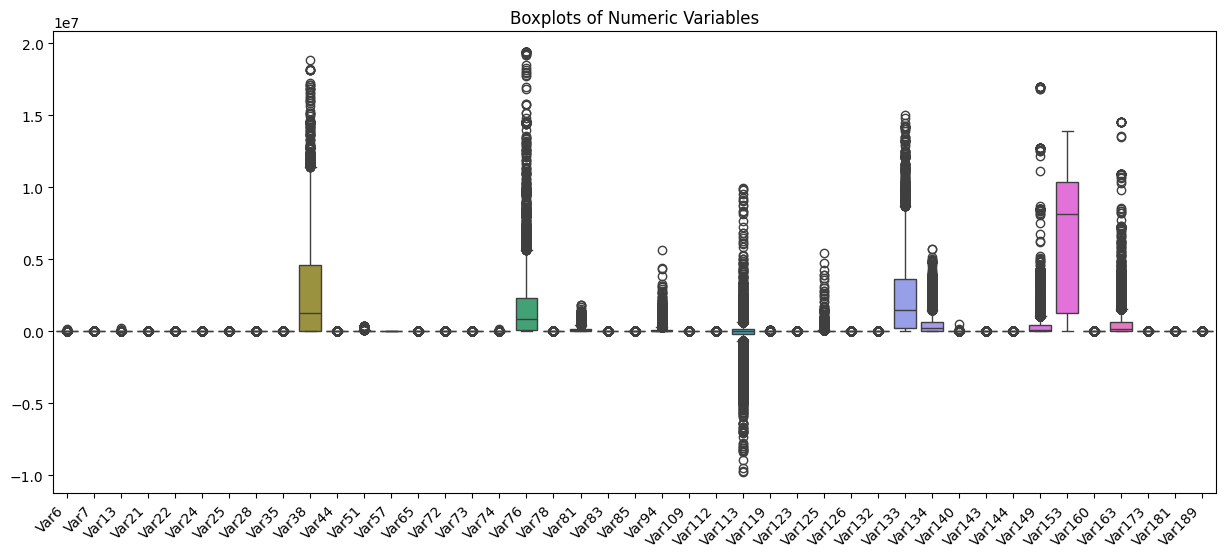

In [ ]:
plot_numeric_boxplots(train_)

### Log-Normalizing the numeric cols to view the distribution

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


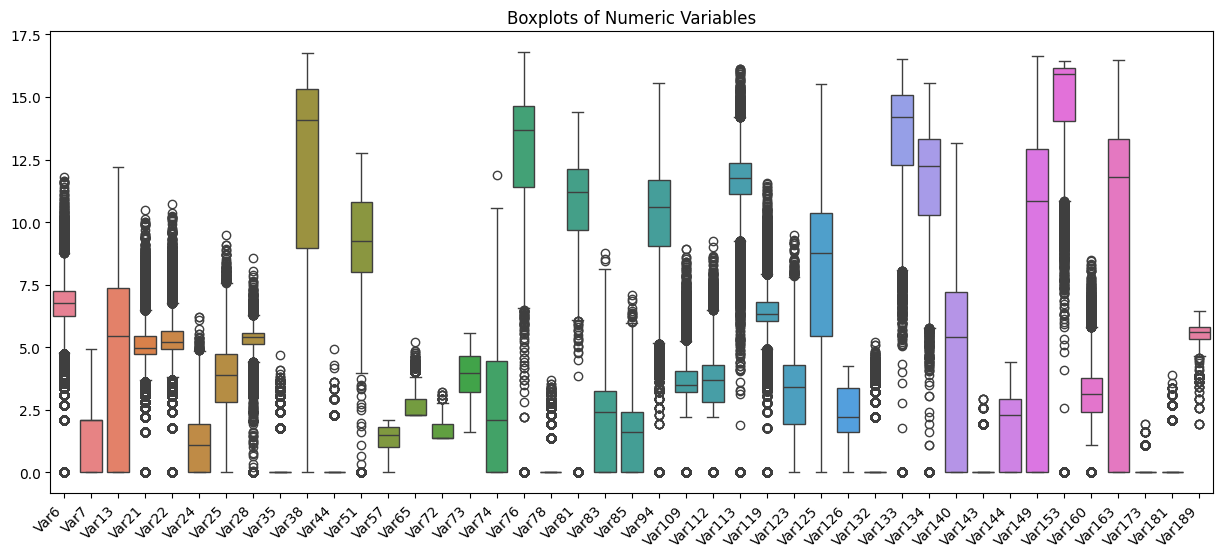

In [ ]:
def log_normalize_numeric_columns(df):
    df_normalized = df.copy()

    numeric_cols = df.select_dtypes(include=np.number).columns

    for col in numeric_cols:
        df_normalized[col] = np.log1p(df[col])

    return df_normalized

train_log_normalized = log_normalize_numeric_columns(train_)
plot_numeric_boxplots(train_log_normalized)

### Checking correlation between the numeric features

<Axes: >

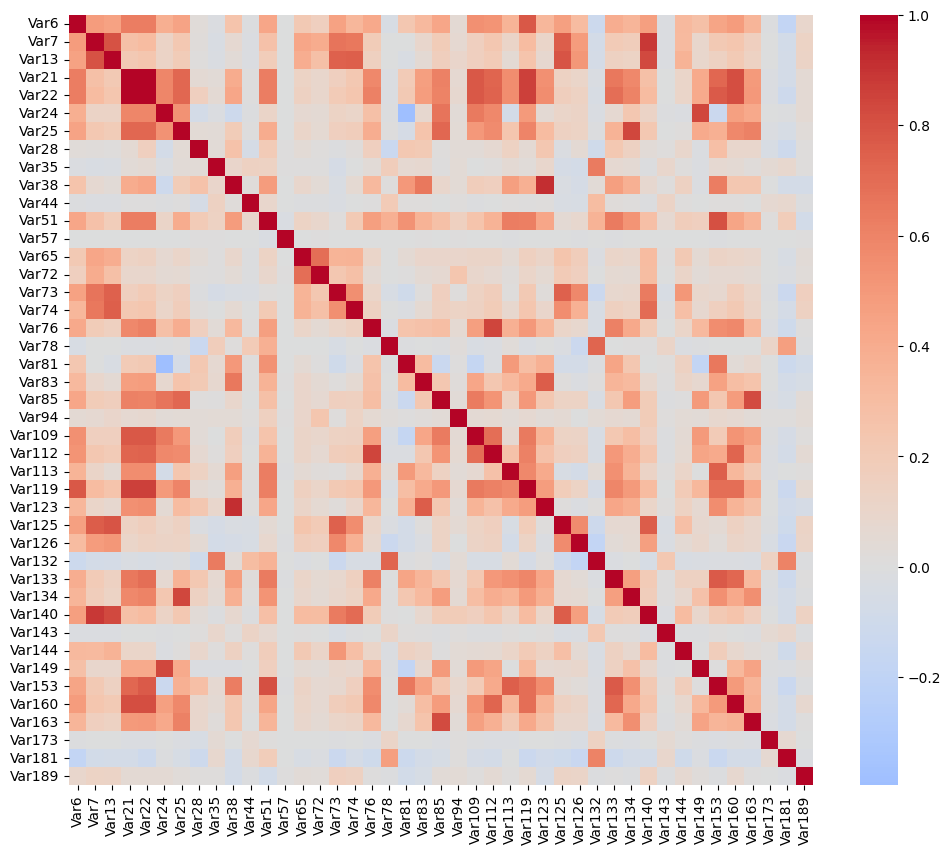

In [ ]:
corr = train_log_normalized.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)

- Removing features with very high correlation as all of them taken together are redundant in predicting the target variable.

<Axes: >

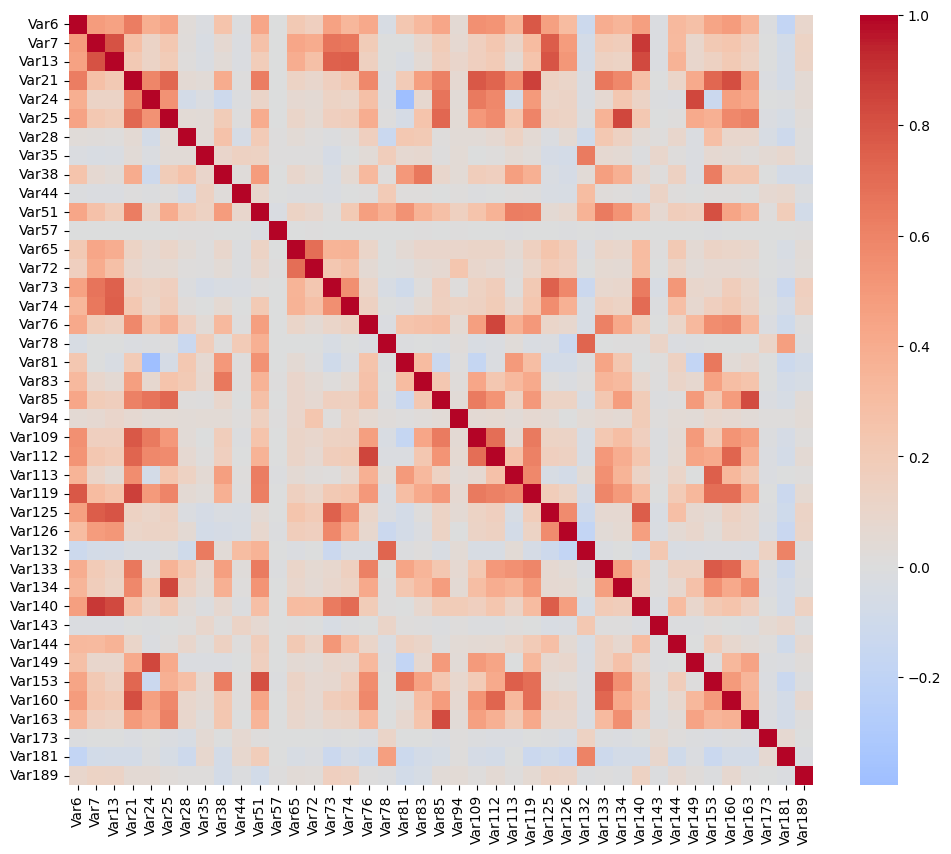

In [ ]:
def get_highly_correlated_features(corr_matrix, threshold=0.90):
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    return [column for column in upper.columns if any(abs(upper[column]) > threshold)]

high_corr_features = get_highly_correlated_features(corr)
train_reduced = train_log_normalized.drop(columns=high_corr_features)

corr_ = train_reduced.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_, cmap='coolwarm', center=0, annot=False)

### Variance Thresholding (Remove Low-Information Features with variance explained is less than 1%)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(train_log_normalized.select_dtypes(include=np.number))
selected_cols = train_log_normalized.select_dtypes(include=np.number).columns[selector.get_support()]

In [ ]:
def plot_feature_variances(df, selected_cols, cumulative_variance_threshold=0.95):
    variances = df[selected_cols].var().sort_values(ascending=False)

    # Calculate cumulative variance explained
    cumulative_variances = np.cumsum(variances.values) / np.sum(variances.values)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    sns.barplot(x=variances.index, y=variances.values, color='skyblue', ax=ax1)
    ax1.set_xticklabels(variances.index, rotation=90)
    ax1.set_ylabel("Variance")

    # A second y-axis for cumulative variance
    ax2 = ax1.twinx()

    # Line plot for cumulative variance explained
    ax2.plot(range(len(variances)), cumulative_variances, color='red', marker='o')
    ax2.set_ylabel("Cumulative Variance Explained")

    # Finding the index where cumulative variance crosses the threshold
    threshold_index = np.argmax(cumulative_variances >= cumulative_variance_threshold)

    # Adding a vertical line at the threshold
    ax2.axvline(x=threshold_index, color='black', linestyle='--', label=f'Cumulative Variance Threshold ({cumulative_variance_threshold:.2f})')


    plt.title("Feature Variance and Cumulative Variance Explained")
    plt.legend()
    plt.tight_layout()
    plt.show()

<ipython-input-15-8ce58250a486>:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(variances.index, rotation=90)


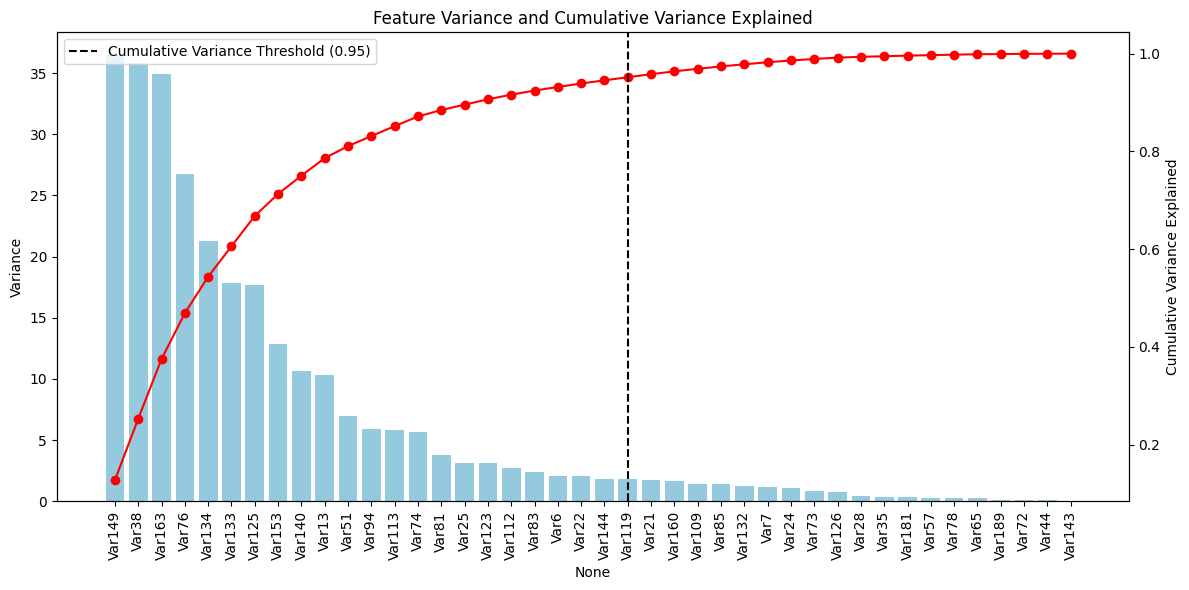

In [ ]:
plot_feature_variances(train_log_normalized, selected_cols)

## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def pca_with_variance_plot(df, selected_cols, n_components=20, cumulative_variance_threshold=0.95):
    """
    Performs PCA and plots explained variance, adding a vertical line at the specified
    cumulative variance threshold.
    """
    # Scale features before PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[selected_cols])

    # Impute missing values using SimpleImputer before applying PCA
    imputer = SimpleImputer(strategy='mean')
    X_scaled = imputer.fit_transform(X_scaled)

    # PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    explained_var = pca.explained_variance_ratio_
    cumulative_var = explained_var.cumsum()

    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(range(1, n_components + 1)), y=explained_var, color='coral', label='Individual Explained Variance')
    sns.lineplot(x=list(range(1, n_components + 1)), y=cumulative_var, marker='o', color='blue', label='Cumulative Variance')

    # Finding the index where cumulative variance crosses the threshold
    threshold_index = np.argmax(cumulative_var >= cumulative_variance_threshold)

    # Adding a vertical line at the threshold
    plt.axvline(x=threshold_index + 1, color='black', linestyle='--', label=f'Cumulative Variance Threshold ({cumulative_variance_threshold:.2f})')  # +1 to align with x-axis

    plt.title("PCA - Explained Variance by Components")
    plt.xlabel("Principal Component")
    plt.ylabel("Explained Variance Ratio")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame({
        'PC': [f'PC{i + 1}' for i in range(n_components)],
        'Explained Variance': explained_var,
        'Cumulative Variance': cumulative_var
    }), pca

In [ ]:
def plot_pca_components_with_target(df, selected_cols, targets, pca_object):

    # Scale and impute data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[selected_cols])

    # imputer = IterativeImputer()
    # X_scaled = imputer.fit_transform(X_scaled)

    imputer = SimpleImputer(strategy='mean')
    X_scaled = imputer.fit_transform(X_scaled)

    # Transform data using the provided PCA object
    X_pca = pca_object.transform(X_scaled)

    # Create a DataFrame with PC1, PC2, and target variable
    pca_df = pd.DataFrame(data=X_pca[:, :2], columns=['PC1', 'PC2'])
    pca_df['target'] = targets

    # Plot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='target', data=pca_df, palette='viridis')
    plt.title('First Two Principal Components with Target Variable')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

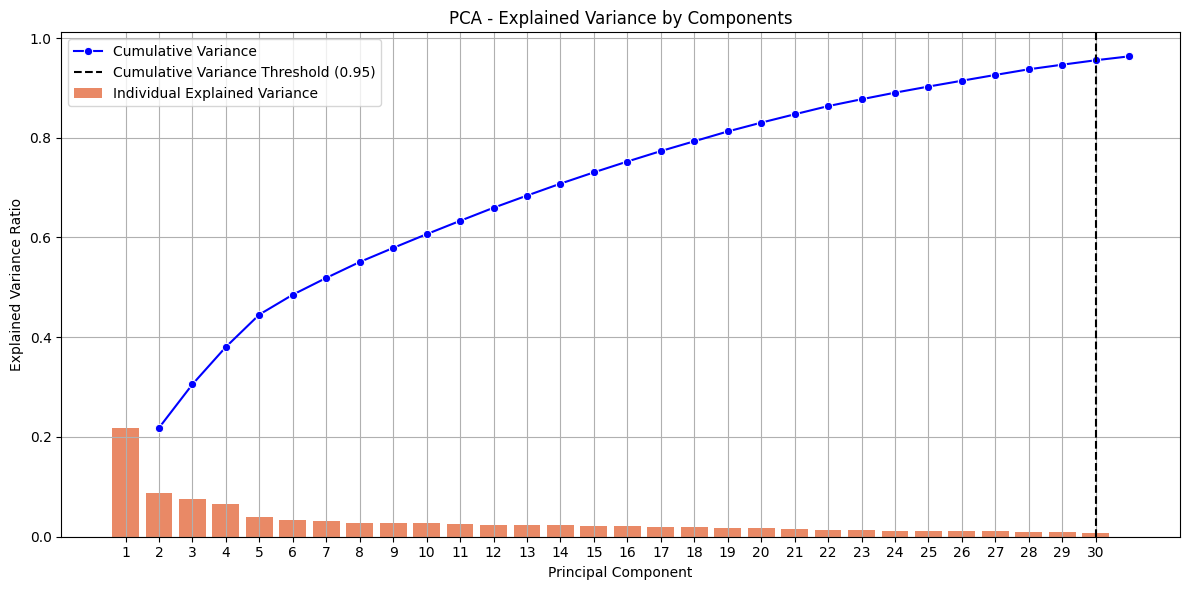

    PC  Explained Variance  Cumulative Variance
0  PC1            0.218303             0.218303
1  PC2            0.087265             0.305568
2  PC3            0.074941             0.380509
3  PC4            0.064956             0.445464
4  PC5            0.039849             0.485314


In [ ]:
# PCA analysis and variance plot
pca_variance_df, pca = pca_with_variance_plot(train_, selected_cols, n_components=30)
print(pca_variance_df.head())

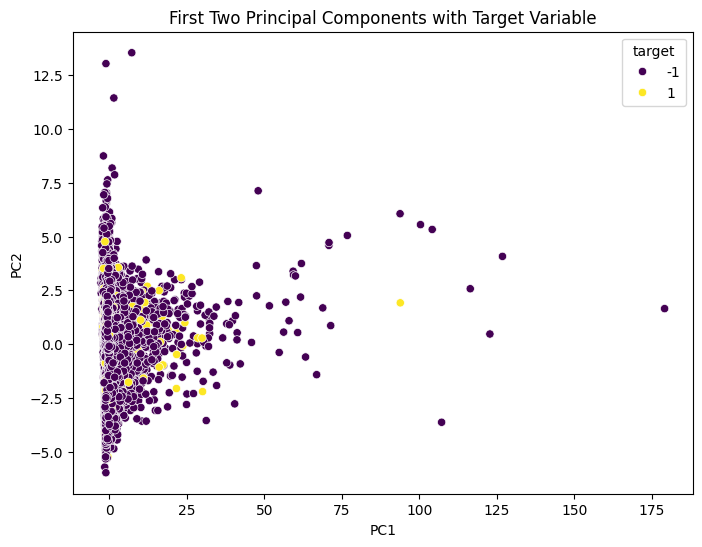

In [ ]:
plot_pca_components_with_target(train_, selected_cols, target['Label'].values, pca)

## Analysis categorical variables

### Removing the very high cardinal features

In [ ]:
def check_categorical_cardinality(df, categorical_cols):
    cardinality = {col: df[col].nunique() for col in categorical_cols}
    cardinality_df = pd.DataFrame(list(cardinality.items()), columns=['Feature', 'Unique Values'])
    cardinality_df = cardinality_df.sort_values(by='Unique Values', ascending=False).reset_index(drop=True)
    return cardinality_df

In [ ]:
categorical_cols = train_reduced.select_dtypes(include=['object', 'category']).columns.tolist()
cardinality_df = check_categorical_cardinality(train_reduced, categorical_cols)
print(cardinality_df.head(10))

  Feature  Unique Values
0  Var214          15415
1  Var200          15415
2  Var217          13990
3  Var202           5713
4  Var199           5073
5  Var220           4291
6  Var222           4291
7  Var198           4291
8  Var216           2016
9  Var192            361


### Chi-Squared Test (for independence):
---
- For evaluating the strength of relationship between remaining categorical features and the binary target.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2

def chi2_test(df, categorical_cols, target, target_col = 'Label'):
    target = target.reset_index(drop=True)

    df_temp = pd.concat([df[categorical_cols], target], axis=1)
    df_temp = df_temp.dropna()

    X = df_temp[categorical_cols].apply(LabelEncoder().fit_transform)
    y = df_temp[target_col].apply(lambda x: 1 if x == 1 else 0)

    chi_scores, p_values = chi2(X, y)

    return pd.DataFrame({
        'Feature': categorical_cols,
        'Chi2 Score': np.round(chi_scores, 3),
        'P-Value': np.round(p_values, 3)
    }).sort_values(by='Chi2 Score', ascending=False)

In [ ]:
chi2_scores_df = chi2_test(train_reduced, categorical_cols, target).reset_index(drop=True)
chi2_scores_df

,Feature,Chi2 Score,P-Value
0,Var200,2181.870,0.000
1,Var216,703.999,0.000
2,Var199,435.175,0.000
3,Var202,353.351,0.000
4,Var198,310.343,0.000
5,Var222,222.744,0.000
6,Var220,166.674,0.000
7,Var193,130.771,0.000
8,Var197,113.162,0.000
9,Var217,84.179,0.000


**Higher Chi-squared score and lower p-value** --> Indicates a stronger relationship between the categorical feature and the target variable. A higher score suggests that the observed frequencies of the categories within the feature are significantly different from what would be expected if there were no relationship with the target.

We can observe filter out features which are statistically significant based on the p-value at 5% significance level

In [ ]:
selected_categorical_cols = chi2_scores_df[chi2_scores_df['P-Value'] < 0.05]['Feature'].tolist()

## Weighted Random Forest to determine the feature importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
def encode_categoricals(df, categorical_cols):
    df_copy = df.copy()
    for col in categorical_cols:
        le = LabelEncoder()
        df_copy[col] = le.fit_transform(df_copy[col].astype(str))
    return df_copy

In [ ]:
# Prepare data
train_reduced_ = train_reduced[[c for c in list(train_reduced.select_dtypes(include = np.number).columns) + selected_categorical_cols]]

df_encoded = encode_categoricals(train_reduced_, selected_categorical_cols)
X = df_encoded
y = target['Label'].apply(lambda x: 1 if x == 1 else 0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 58), (10000, 58), (40000,), (10000,))

In [ ]:
from sklearn.metrics import (make_scorer, roc_auc_score)
from sklearn.model_selection import GridSearchCV

auc_scorer = make_scorer(roc_auc_score)
scorer = auc_scorer

param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

grid_search = GridSearchCV(clf, param_grid, scoring=scorer, cv=5)
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_

In [ ]:
# Getting feature importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [ ]:
def plot_feature_importance(importances_df, top_n=30):
    plt.figure(figsize=(12, 8))
    sns.barplot(data=importances_df.head(top_n), x='Importance', y='Feature', palette='viridis')
    plt.title(f'Top {top_n} Feature Importances from Random Forest')
    plt.tight_layout()
    plt.show()

<ipython-input-79-608c48fe9124>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importances_df.head(top_n), x='Importance', y='Feature', palette='viridis')


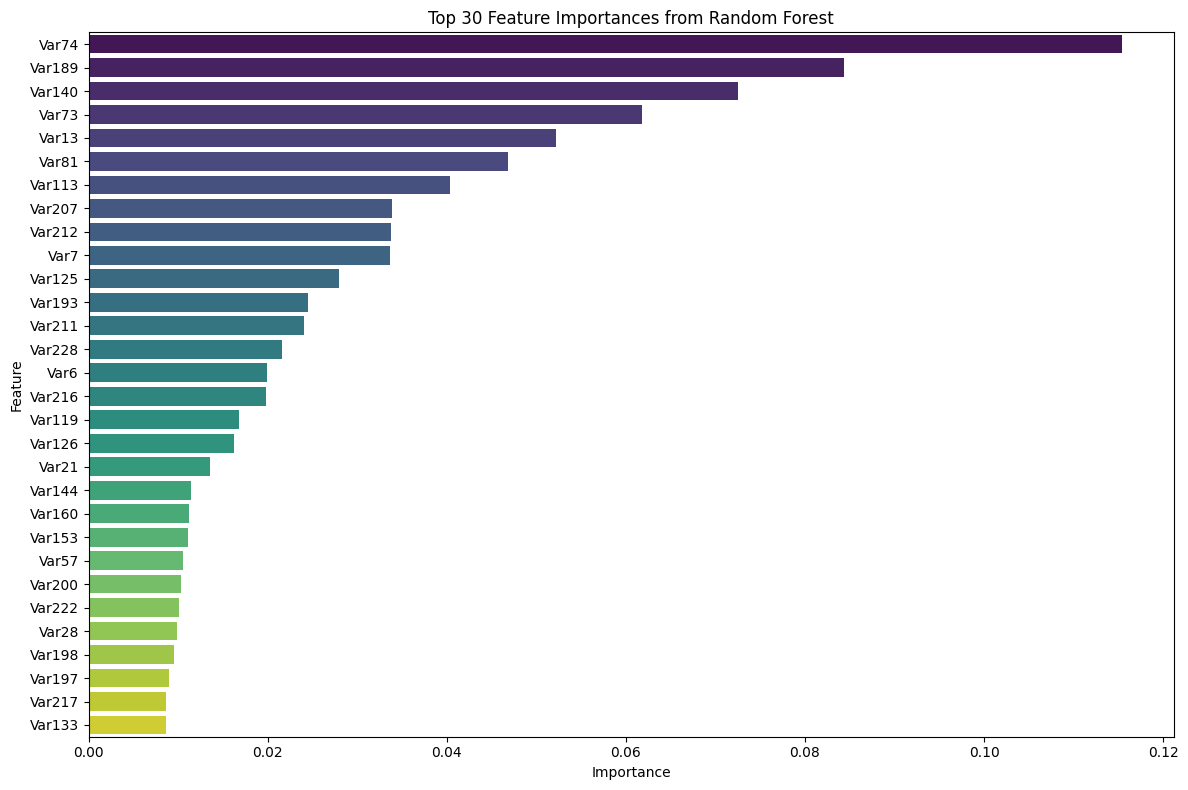

In [ ]:
plot_feature_importance(feature_importances, top_n=30)

In [ ]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, RocCurveDisplay,
    classification_report
)

def evaluate_classifier(clf, X_test, y_test):
    y_probs = clf.predict_proba(X_test)[:, 1]
    y_preds = clf.predict(X_test)

    # AUC Score
    auc = roc_auc_score(y_test, y_probs)
    print(f"AUC Score: {auc:.4f}")

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_preds))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title("ROC Curve")
    plt.grid(True)
    plt.show()

AUC Score: 0.6458

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.67      0.79      9266
           1       0.11      0.53      0.19       734

    accuracy                           0.66     10000
   macro avg       0.53      0.60      0.49     10000
weighted avg       0.89      0.66      0.74     10000



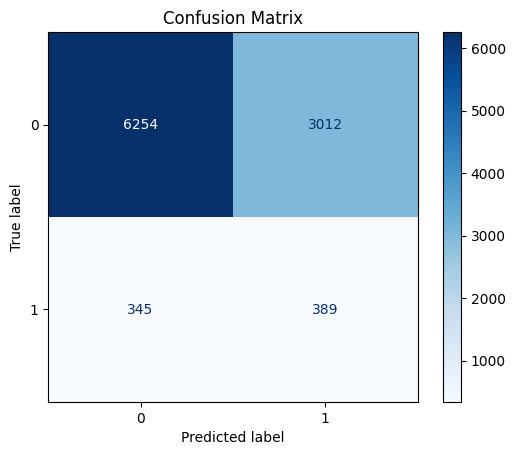

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


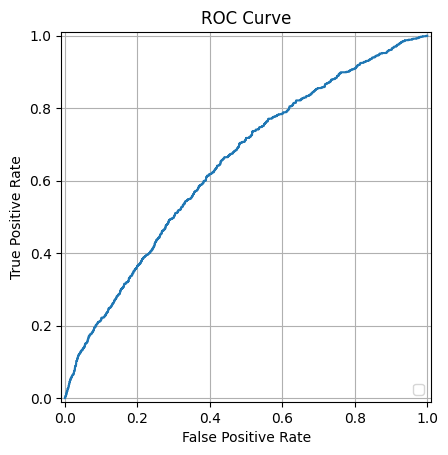

In [ ]:
## Evaluating balanced Random Forest classifier
evaluate_classifier(best_clf, X_test, y_test)

In [ ]:
!pip install imblearn --quiet

AUC Score: 0.6003

Classification Report:

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      9266
           1       0.00      0.00      0.00       734

    accuracy                           0.93     10000
   macro avg       0.46      0.50      0.48     10000
weighted avg       0.86      0.93      0.89     10000



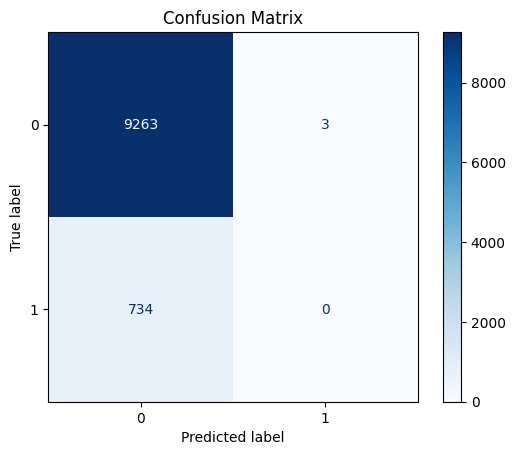

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


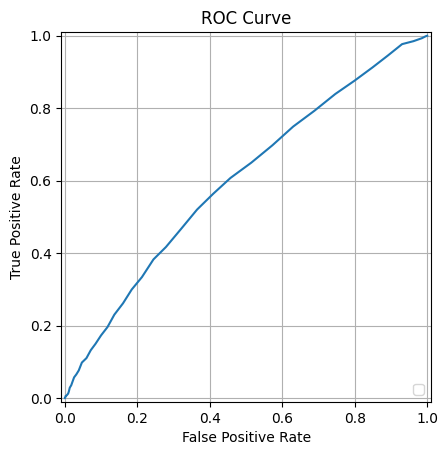

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transforming both X_train and X_test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

clf_os = RandomForestClassifier(n_estimators=100, random_state=42)
clf_os.fit(X_train_resampled, y_train_resampled)

## Evaluating balanced Random Forest classifier
evaluate_classifier(clf_os, X_test_imputed, y_test)

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

hgb_clf = HistGradientBoostingClassifier(random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
}

grid_search = GridSearchCV(hgb_clf, param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

best_hgb_clf = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best AUC Score: {grid_search.best_score_}")

best_hgb_clf.fit(X_train, y_train)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 100}
Best AUC Score: 0.6770640227474013


HistGradientBoostingClassifier(max_depth=3, random_state=42)

AUC Score: 0.6593

Classification Report:

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      9266
           1       0.00      0.00      0.00       734

    accuracy                           0.93     10000
   macro avg       0.46      0.50      0.48     10000
weighted avg       0.86      0.93      0.89     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


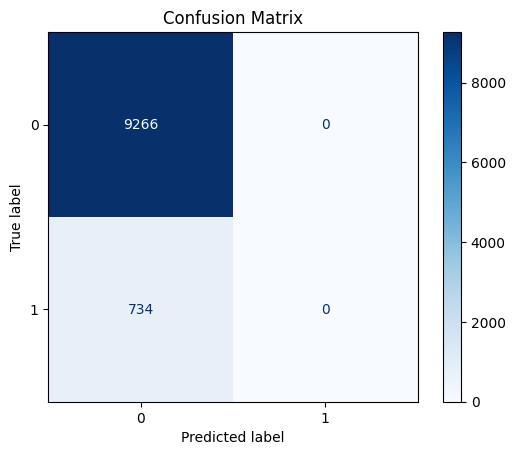

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


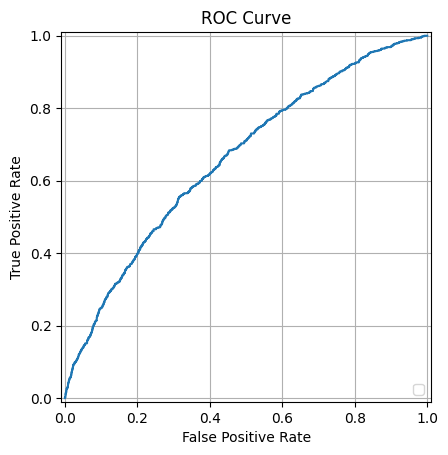

In [ ]:
evaluate_classifier(best_hgb_clf, X_test, y_test)

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

hgb_clf = HistGradientBoostingClassifier(random_state=42)

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'max_iter': [50, 100, 200],
    'max_depth': [3, 7, 11],
}

grid_search = GridSearchCV(hgb_clf, param_grid, scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

best_hgb_clf = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best F1 Score: {grid_search.best_score_}")

best_hgb_clf.fit(X_train, y_train)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'max_iter': 50}
Best AUC Score: 0.003394438607649327


HistGradientBoostingClassifier(max_depth=7, max_iter=50, random_state=42)

AUC Score: 0.6595

Classification Report:

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      9266
           1       0.60      0.00      0.01       734

    accuracy                           0.93     10000
   macro avg       0.76      0.50      0.49     10000
weighted avg       0.90      0.93      0.89     10000



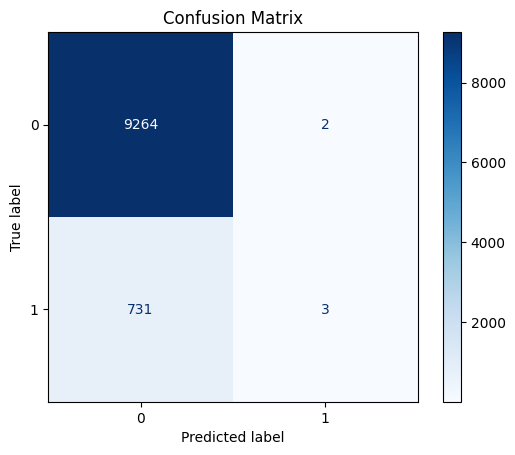

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


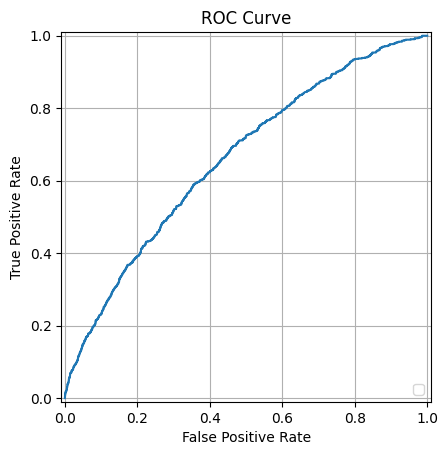

In [ ]:
evaluate_classifier(best_hgb_clf, X_test, y_test)